<a href="https://colab.research.google.com/github/businsweetie/deep_learning/blob/main/Task_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек и функции

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers

from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, classification_report
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
def plot_training_curves(history):
  loss_values = history.history['loss'] # ошибка на тренировочном наборе
  val_loss_values = history.history['val_loss'] # ошибка на валидационном наборе
  acc_values = history.history['accuracy']  # точность на тренировочном наборе
  val_acc_values = history.history['val_accuracy'] # точность на валидационном наборе

  epochs_x = range(1, len(loss_values) + 1) # количество эпох обучения

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # график значения функции потерь на каждой эпохе
  ax1.plot(epochs_x, loss_values, 'b-o', label='Ошибка обучения')
  ax1.plot(epochs_x, val_loss_values, 'r-o', label='Ошибка валидации')
  ax1.set_title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  ax1.set_xlabel('Эпохи', fontsize=12)
  ax1.set_ylabel('Значение ошибки', fontsize=12)
  ax1.grid()
  ax1.legend()

  # график значения точности на каждой эпохе
  ax2.plot(epochs_x, acc_values, 'b-o', label='Точность обучения')
  ax2.plot(epochs_x, val_acc_values, 'r-o', label='Точность валидации')
  ax2.set_title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  ax2.set_xlabel('Эпохи', fontsize=12)
  ax2.set_ylabel('Значение точности', fontsize=12)
  ax2.grid()
  ax2.legend()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='PuBu', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  cm = confusion_matrix(y_test, y_predicted)
  accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted")
  model_roc_auc = roc_auc_score(y_true, y_probabilities, multi_class="ovr")

  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'F1_score:\t\t{model_f1:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')
  print("")
  for i in range(len(accuracy_per_class)):
    print(f"Accuracy Score {i}:\t{accuracy_per_class[i]:.4f}")
  print("")
  print(classification_report(y_test, y_predicted))

  return

def plot_multiclass_roc(y_test, y_prob, n_classes, figsize=(5,5)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title("График ROC-кривой", fontsize=14, fontweight="bold")
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='AUC = %0.3f for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

# Загрузка набора данных

In [3]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 24 02:47 kaggle.json


In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [6]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d kukuroo3/body-performance-data

  0% 0.00/249k [00:00<?, ?B/s]
100% 249k/249k [00:00<00:00, 79.0MB/s]


# Чтение данных

In [8]:
# разархивирование данных
!unzip "/content/body-performance-data.zip" -d "/content/body"

Archive:  /content/body-performance-data.zip
  inflating: /content/body/bodyPerformance.csv  


In [9]:
df = pd.read_csv('/content/body/bodyPerformance.csv') # читаем данные в перменную df
df.head() # выводим первые 5 строк

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


# Исследование данных

In [10]:
df = df.rename(columns={"body fat_%": "body_fat",
                        "sit and bend forward_cm": "sit_bend_forward_cm",
                        "sit-ups counts": "sit_ups_counts",
                        "broad jump_cm": "broad_jump_cm"}
          )
df.head()

,age,gender,height_cm,weight_kg,body_fat,diastolic,systolic,gripForce,sit_bend_forward_cm,sit_ups_counts,broad_jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [11]:
lb = LabelEncoder()
df['class'] = lb.fit_transform(df['class'])
class_names = lb.classes_

In [12]:
df = df.replace({'M':0, 'F':1})

In [13]:
df.describe() # информация о числовых характеристиках переменных

,age,gender,height_cm,weight_kg,body_fat,diastolic,systolic,gripForce,sit_bend_forward_cm,sit_ups_counts,broad_jump_cm,class
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,0.367804,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627,1.500187
std,13.625639,0.482226,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000,1.118109
min,21.000000,0.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000,1.000000
50%,32.000000,0.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000,2.000000
75%,48.000000,1.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000,3.000000
max,64.000000,1.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000,3.000000


In [14]:
df.info() # информация о пропущенных знначениях и типах переменной

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  13393 non-null  float64
 1   gender               13393 non-null  int64  
 2   height_cm            13393 non-null  float64
 3   weight_kg            13393 non-null  float64
 4   body_fat             13393 non-null  float64
 5   diastolic            13393 non-null  float64
 6   systolic             13393 non-null  float64
 7   gripForce            13393 non-null  float64
 8   sit_bend_forward_cm  13393 non-null  float64
 9   sit_ups_counts       13393 non-null  float64
 10  broad_jump_cm        13393 non-null  float64
 11  class                13393 non-null  int64  
dtypes: float64(10), int64(2)
memory usage: 1.2 MB


In [15]:
unique_values = {}
for col in df.columns:
    unique_values[col] = df[col].value_counts().shape[0]

pd.DataFrame(unique_values, index=['Количество уникальных значений']).transpose()

,Количество уникальных значений
age,44
gender,2
height_cm,467
weight_kg,1398
body_fat,527
diastolic,89
systolic,102
gripForce,550
sit_bend_forward_cm,528
sit_ups_counts,81


In [16]:
df.duplicated().sum()

1

In [17]:
df = df.drop_duplicates()
df.duplicated().sum()

0

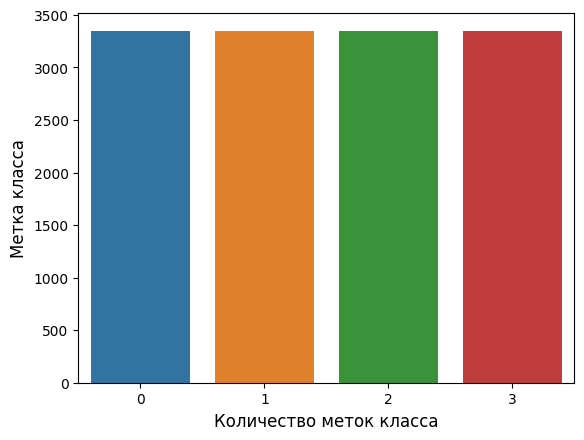

In [18]:
# визуализация количества меток класса
sns.countplot(x=df['class'] ,data=df)
plt.xlabel("Количество меток класса", fontsize=12)
plt.ylabel("Метка класса", fontsize=12)
plt.show()

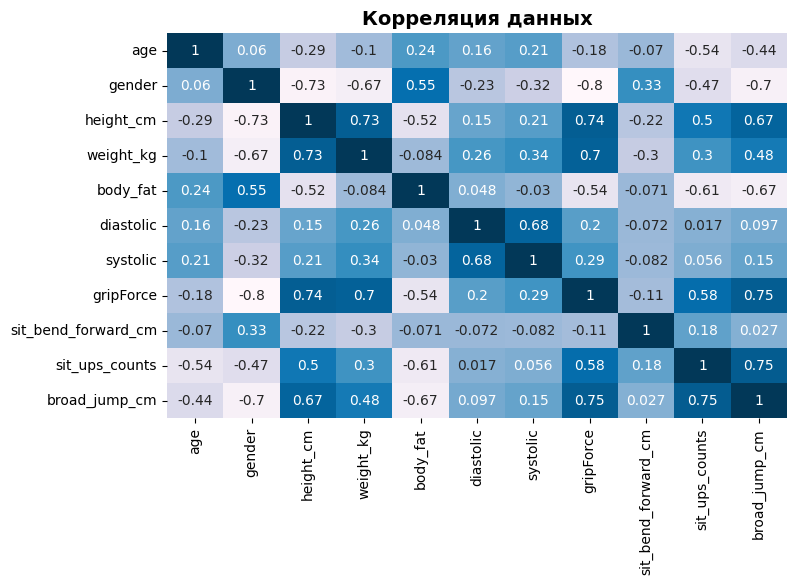

In [19]:
plt.figure(figsize = (8, 5))
sns.heatmap(df.drop("class", axis=1).corr(), annot=True, cmap ='PuBu', cbar=False)
plt.title("Корреляция данных", fontsize=14, fontweight="bold");

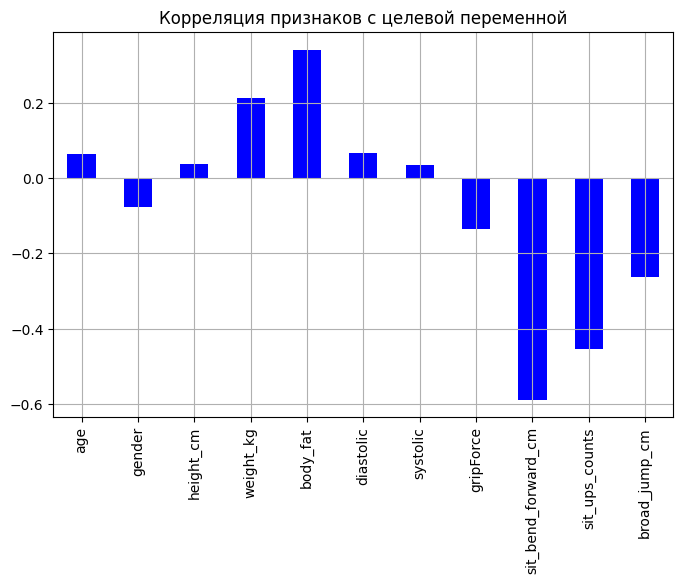

In [20]:
df.drop('class', axis=1).corrwith(df["class"]).plot(kind='bar',
                                                    grid=True,
                                                    figsize=(8, 5),
                                                    title="Корреляция признаков с целевой переменной",
                                                    color="blue");

In [150]:
corr = df.corr()
corr["class"]

age                    0.065546
gender                -0.075483
height_cm              0.037621
weight_kg              0.214008
body_fat               0.342095
diastolic              0.066685
systolic               0.035197
gripForce             -0.136188
sit_bend_forward_cm   -0.588115
sit_ups_counts        -0.452794
broad_jump_cm         -0.262233
class                  1.000000
Name: class, dtype: float64

In [152]:
th=0.1

corr_th = corr["class"][abs(corr["class"]) > th]
corr_th

weight_kg              0.214008
body_fat               0.342095
gripForce             -0.136188
sit_bend_forward_cm   -0.588115
sit_ups_counts        -0.452794
broad_jump_cm         -0.262233
class                  1.000000
Name: class, dtype: float64

In [154]:
df_new_features = df.drop(corr["class"][abs(corr["class"]) <= th].keys(), axis=1)
df_new_features.head()

,weight_kg,body_fat,gripForce,sit_bend_forward_cm,sit_ups_counts,broad_jump_cm,class
0,75.24,21.3,54.9,18.4,60.0,217.0,2
1,55.80,15.7,36.4,16.3,53.0,229.0,0
2,78.00,20.1,44.8,12.0,49.0,181.0,2
3,71.10,18.4,41.4,15.2,53.0,219.0,1
4,67.70,17.1,43.5,27.1,45.0,217.0,1


# Деление на выборки

In [93]:
# делим выборку на тренировочную и тестовую
X = df.drop(['class'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df['class'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [94]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [95]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (8570, 11)
Размер тестовой выборки: (2679, 11)
Размер валидационной выборки: (2143, 11)


In [96]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Создание модели

In [29]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [97]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [98]:
# компиляция модели
model1.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 12)                144       
                                                                 
 dense_66 (Dense)            (None, 8)                 104       
                                                                 
 dense_67 (Dense)            (None, 4)                 36        
                                                                 
 dense_68 (Dense)            (None, 4)                 20        
                                                                 
Total params: 304 (1.19 KB)
Trainable params: 304 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [99]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
268/268 [==============================] - 2s 3ms/step - loss: 1.2811 - accuracy: 0.3901 - val_loss: 1.1048 - val_accuracy: 0.4778
Epoch 2/50
268/268 [==============================] - 1s 3ms/step - loss: 1.0255 - accuracy: 0.5061 - val_loss: 0.9731 - val_accuracy: 0.5488
Epoch 3/50
268/268 [==============================] - 1s 3ms/step - loss: 0.9322 - accuracy: 0.5683 - val_loss: 0.9162 - val_accuracy: 0.5866
Epoch 4/50
268/268 [==============================] - 1s 2ms/step - loss: 0.8810 - accuracy: 0.6120 - val_loss: 0.8831 - val_accuracy: 0.6085
Epoch 5/50
268/268 [==============================] - 1s 3ms/step - loss: 0.8489 - accuracy: 0.6279 - val_loss: 0.8577 - val_accuracy: 0.6253
Epoch 6/50
268/268 [==============================] - 1s 3ms/step - loss: 0.8258 - accuracy: 0.6400 - val_loss: 0.8381 - val_accuracy: 0.6323
Epoch 7/50
268/268 [==============================] - 1s 4ms/step - loss: 0.8051 - accuracy: 0.6524 - val_loss: 0.8183 - val_accuracy: 0.6458
Epoch 

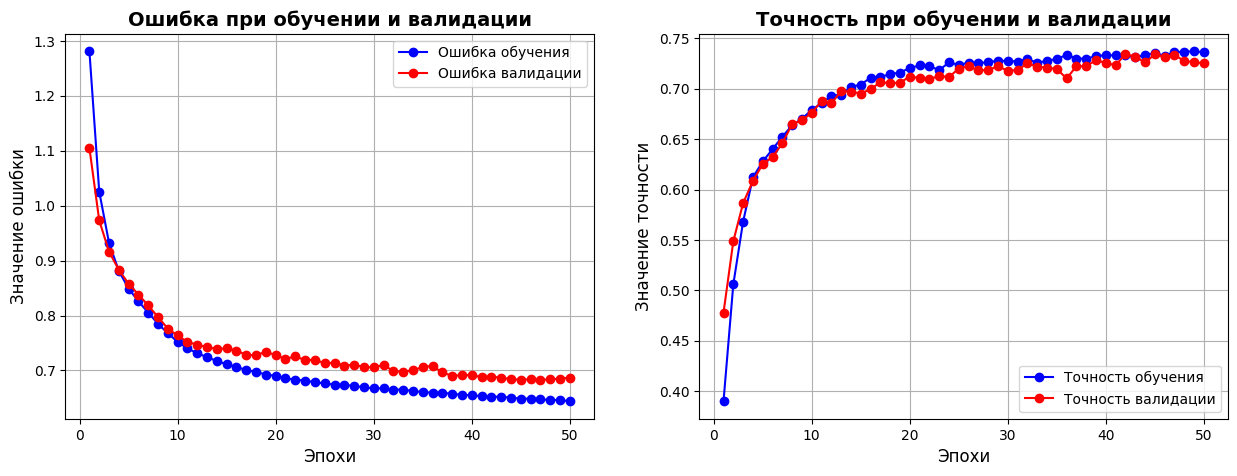

In [100]:
plot_training_curves(history1)

In [101]:
y_predicted_prob = model1.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 1ms/step


In [102]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7317
Precision_score:	0.7400
Recall_score:		0.7316
F1_score:		0.7321
AUC Score:		0.9109

Accuracy Score 0:	0.8709
Accuracy Score 1:	0.5950
Accuracy Score 2:	0.6834
Accuracy Score 3:	0.7773

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       674
           1       0.61      0.59      0.60       679
           2       0.70      0.68      0.69       657
           3       0.93      0.78      0.85       669

    accuracy                           0.73      2679
   macro avg       0.74      0.73      0.73      2679
weighted avg       0.74      0.73      0.73      2679



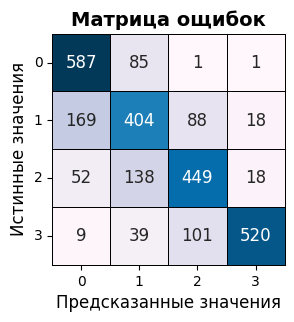

In [103]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

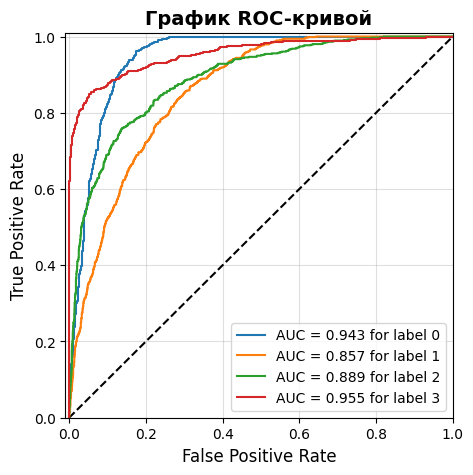

In [104]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 1 оптимизатор RMSprop

In [105]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [106]:
# компиляция модели
model1.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 12)                144       
                                                                 
 dense_70 (Dense)            (None, 8)                 104       
                                                                 
 dense_71 (Dense)            (None, 4)                 36        
                                                                 
 dense_72 (Dense)            (None, 4)                 20        
                                                                 
Total params: 304 (1.19 KB)
Trainable params: 304 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [107]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=50,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/50
268/268 [==============================] - 2s 4ms/step - loss: 1.3193 - accuracy: 0.3931 - val_loss: 1.2268 - val_accuracy: 0.5012
Epoch 2/50
268/268 [==============================] - 1s 3ms/step - loss: 1.1827 - accuracy: 0.5292 - val_loss: 1.1280 - val_accuracy: 0.5567
Epoch 3/50
268/268 [==============================] - 1s 3ms/step - loss: 1.0960 - accuracy: 0.5719 - val_loss: 1.0547 - val_accuracy: 0.5908
Epoch 4/50
268/268 [==============================] - 1s 3ms/step - loss: 1.0333 - accuracy: 0.5972 - val_loss: 1.0005 - val_accuracy: 0.6113
Epoch 5/50
268/268 [==============================] - 1s 3ms/step - loss: 0.9641 - accuracy: 0.6161 - val_loss: 0.9225 - val_accuracy: 0.6216
Epoch 6/50
268/268 [==============================] - 1s 3ms/step - loss: 0.8932 - accuracy: 0.6282 - val_loss: 0.8694 - val_accuracy: 0.6444
Epoch 7/50
268/268 [==============================] - 1s 4ms/step - loss: 0.8478 - accuracy: 0.6485 - val_loss: 0.8325 - val_accuracy: 0.6556
Epoch 

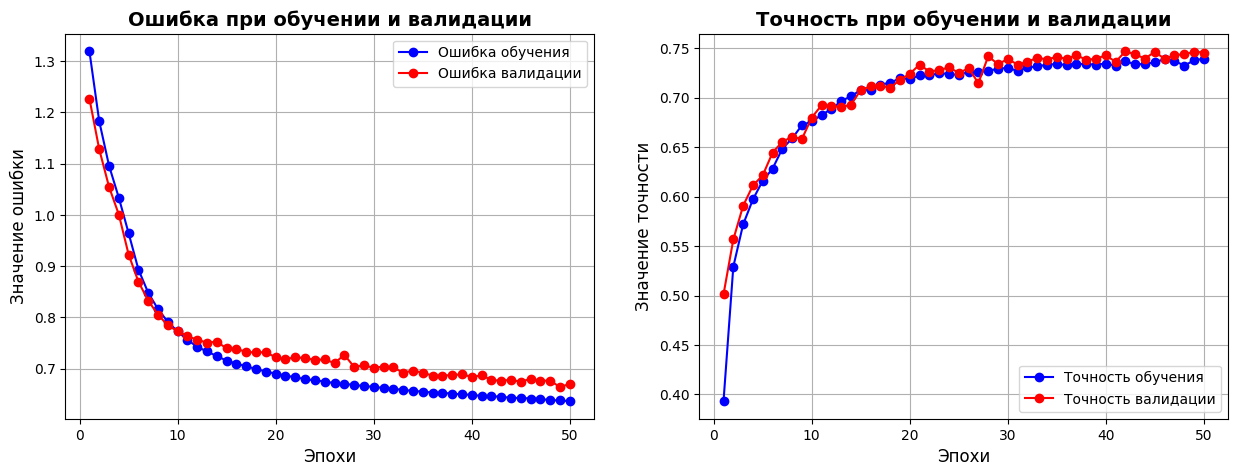

In [108]:
plot_training_curves(history1)

In [109]:
y_predicted_prob = model1.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 2ms/step


In [110]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7336
Precision_score:	0.7393
Recall_score:		0.7339
F1_score:		0.7335
AUC Score:		0.9108

Accuracy Score 0:	0.8694
Accuracy Score 1:	0.6200
Accuracy Score 2:	0.6301
Accuracy Score 3:	0.8146

              precision    recall  f1-score   support

           0       0.73      0.87      0.79       674
           1       0.60      0.62      0.61       679
           2       0.74      0.63      0.68       657
           3       0.90      0.81      0.85       669

    accuracy                           0.73      2679
   macro avg       0.74      0.73      0.73      2679
weighted avg       0.74      0.73      0.73      2679



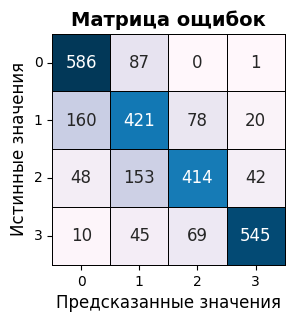

In [111]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

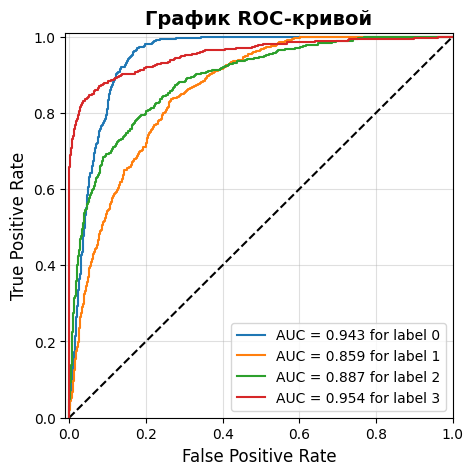

In [112]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 2 оптимизатор RMSprop

In [163]:
model2 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(4, activation="softmax")
])

In [164]:
# компиляция модели
model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_127 (Dense)           (None, 32)                384       
                                                                 
 dense_128 (Dense)           (None, 64)                2112      
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_129 (Dense)           (None, 64)                4160      
                                                                 
 dropout_31 (Dropout)        (None, 64)                0         
                                                                 
 dense_130 (Dense)           (None, 32)                2080      
                                                                 
 dense_131 (Dense)           (None, 16)              

### Обучение

In [165]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/100
268/268 [==============================] - 2s 4ms/step - loss: 1.0643 - accuracy: 0.4995 - val_loss: 0.8756 - val_accuracy: 0.6048
Epoch 2/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8659 - accuracy: 0.6081 - val_loss: 0.8211 - val_accuracy: 0.6393
Epoch 3/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8161 - accuracy: 0.6386 - val_loss: 0.7762 - val_accuracy: 0.6715
Epoch 4/100
268/268 [==============================] - 1s 3ms/step - loss: 0.7828 - accuracy: 0.6606 - val_loss: 0.7729 - val_accuracy: 0.6701
Epoch 5/100
268/268 [==============================] - 1s 3ms/step - loss: 0.7573 - accuracy: 0.6800 - val_loss: 0.7481 - val_accuracy: 0.7000
Epoch 6/100
268/268 [==============================] - 1s 3ms/step - loss: 0.7343 - accuracy: 0.6949 - val_loss: 0.7422 - val_accuracy: 0.6972
Epoch 7/100
268/268 [==============================] - 1s 3ms/step - loss: 0.7179 - accuracy: 0.6996 - val_loss: 0.7389 - val_accuracy: 0.7121

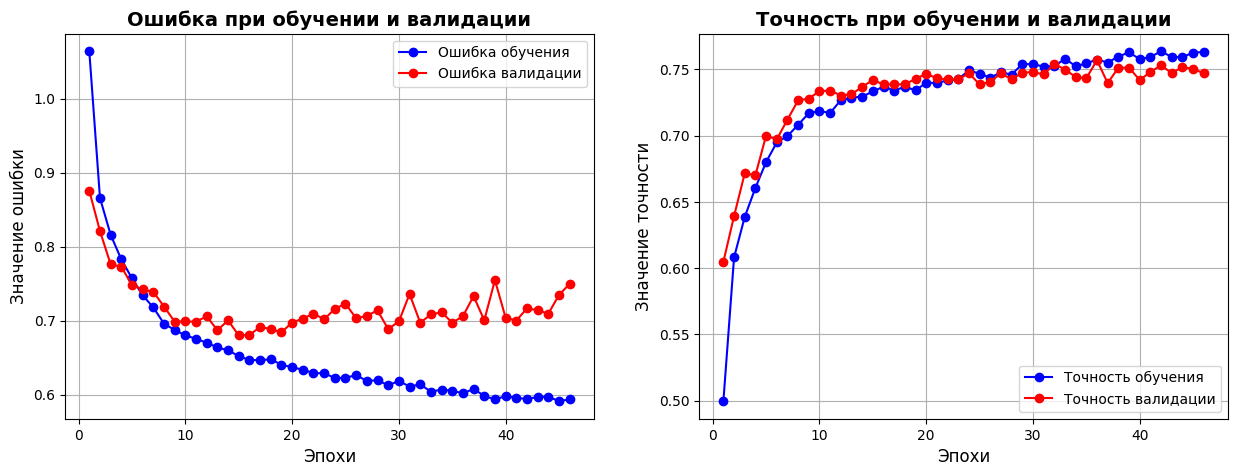

In [171]:
plot_training_curves(history2)

In [167]:
y_predicted_prob = model2.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 1ms/step


In [168]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7368
Precision_score:	0.7427
Recall_score:		0.7368
F1_score:		0.7375
AUC Score:		0.9187

Accuracy Score 0:	0.8412
Accuracy Score 1:	0.6244
Accuracy Score 2:	0.6682
Accuracy Score 3:	0.8132

              precision    recall  f1-score   support

           0       0.72      0.84      0.77       674
           1       0.61      0.62      0.62       679
           2       0.74      0.67      0.70       657
           3       0.91      0.81      0.86       669

    accuracy                           0.74      2679
   macro avg       0.74      0.74      0.74      2679
weighted avg       0.74      0.74      0.74      2679



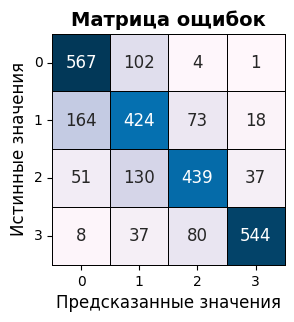

In [169]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

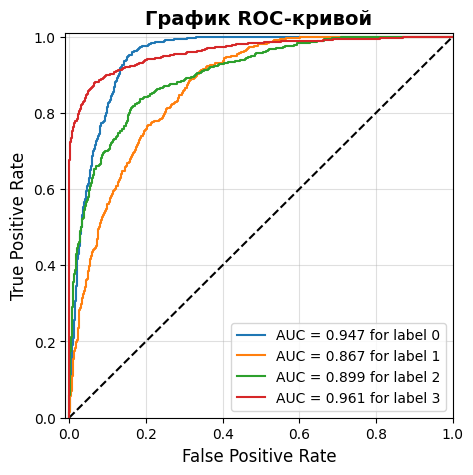

In [170]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 2 оптимизатор RMSprop больше do

In [172]:
model2 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(4, activation="softmax")
])

In [173]:
# компиляция модели
model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 32)                384       
                                                                 
 dense_134 (Dense)           (None, 64)                2112      
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 dense_135 (Dense)           (None, 64)                4160      
                                                                 
 dropout_33 (Dropout)        (None, 64)                0         
                                                                 
 dense_136 (Dense)           (None, 32)                2080      
                                                                 
 dense_137 (Dense)           (None, 16)              

### Обучение

In [174]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/100
268/268 [==============================] - 3s 5ms/step - loss: 1.1008 - accuracy: 0.4754 - val_loss: 0.9095 - val_accuracy: 0.5828
Epoch 2/100
268/268 [==============================] - 1s 3ms/step - loss: 0.9055 - accuracy: 0.5894 - val_loss: 0.8366 - val_accuracy: 0.6379
Epoch 3/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8502 - accuracy: 0.6260 - val_loss: 0.8113 - val_accuracy: 0.6444
Epoch 4/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8174 - accuracy: 0.6496 - val_loss: 0.7828 - val_accuracy: 0.6738
Epoch 5/100
268/268 [==============================] - 1s 3ms/step - loss: 0.7936 - accuracy: 0.6559 - val_loss: 0.7691 - val_accuracy: 0.6804
Epoch 6/100
268/268 [==============================] - 1s 3ms/step - loss: 0.7762 - accuracy: 0.6644 - val_loss: 0.7585 - val_accuracy: 0.6948
Epoch 7/100
268/268 [==============================] - 1s 3ms/step - loss: 0.7552 - accuracy: 0.6767 - val_loss: 0.7395 - val_accuracy: 0.7065

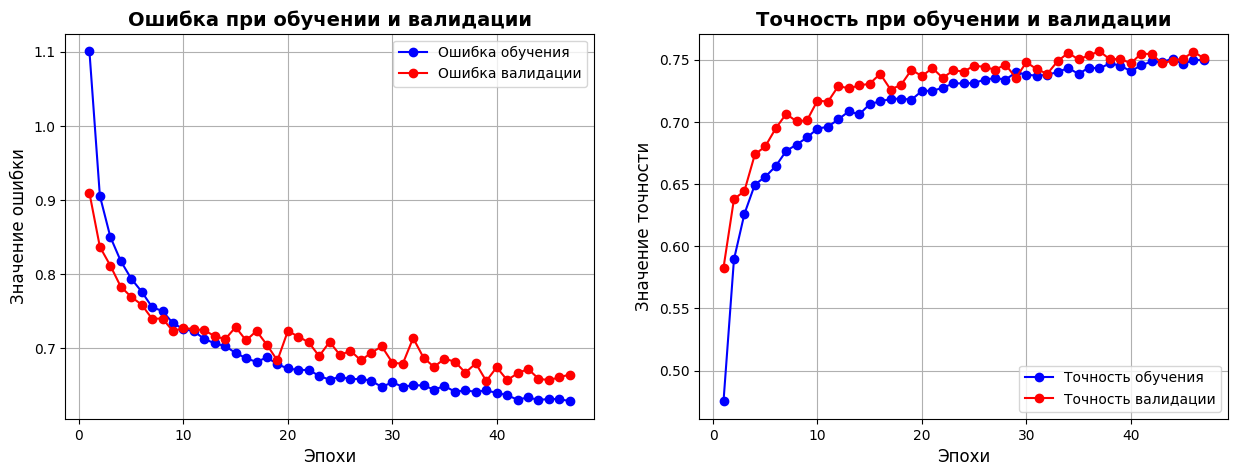

In [175]:
plot_training_curves(history2)

In [176]:
y_predicted_prob = model2.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 1ms/step


In [177]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.7386
Precision_score:	0.7453
Recall_score:		0.7387
F1_score:		0.7406
AUC Score:		0.9159

Accuracy Score 0:	0.8101
Accuracy Score 1:	0.6524
Accuracy Score 2:	0.6773
Accuracy Score 3:	0.8146

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       674
           1       0.60      0.65      0.63       679
           2       0.73      0.68      0.70       657
           3       0.91      0.81      0.86       669

    accuracy                           0.74      2679
   macro avg       0.75      0.74      0.74      2679
weighted avg       0.75      0.74      0.74      2679



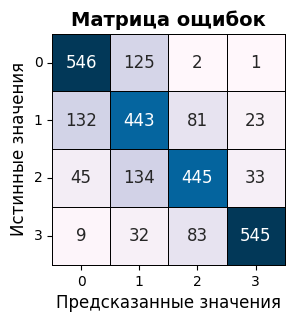

In [178]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

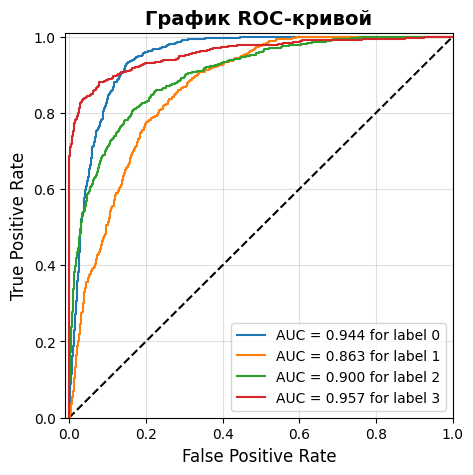

In [179]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

# Деление на выборки

In [180]:
# делим выборку на тренировочную и тестовую
X = df_new_features.drop(['class'],axis=1).values # удаляем целевую переменную из общего набора данных
y = df_new_features['class'].values # создаем отделтнуб переменную для целевого признака
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и тестовый в соотношениии 80/20 (train/test)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size = 0.2, random_state = 0) # делим набор данных на тренировочный и валидационный в соотношениии 80/20 (train/test)

In [181]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [182]:
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Размер валидационной выборки: {X_val.shape}")

Размер тренировочной выборки: (8570, 6)
Размер тестовой выборки: (2679, 6)
Размер валидационной выборки: (2143, 6)


In [183]:
# проводим стандартизацию данных, для лучшей работы нейронной сети
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Модель 1 оптимизатор RMSprop

In [192]:
model1 = keras.Sequential([
    layers.Dense(12, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [193]:
# компиляция модели
model1.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model1.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 12)                84        
                                                                 
 dense_144 (Dense)           (None, 8)                 104       
                                                                 
 dense_145 (Dense)           (None, 4)                 36        
                                                                 
 dense_146 (Dense)           (None, 4)                 20        
                                                                 
Total params: 244 (976.00 Byte)
Trainable params: 244 (976.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Обучение

In [194]:
history1 = model1.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/100
268/268 [==============================] - 2s 5ms/step - loss: 1.3229 - accuracy: 0.3903 - val_loss: 1.1966 - val_accuracy: 0.4872
Epoch 2/100
268/268 [==============================] - 1s 4ms/step - loss: 1.0970 - accuracy: 0.5062 - val_loss: 1.0383 - val_accuracy: 0.5208
Epoch 3/100
268/268 [==============================] - 1s 3ms/step - loss: 1.0042 - accuracy: 0.5382 - val_loss: 0.9907 - val_accuracy: 0.5427
Epoch 4/100
268/268 [==============================] - 1s 2ms/step - loss: 0.9699 - accuracy: 0.5547 - val_loss: 0.9654 - val_accuracy: 0.5590
Epoch 5/100
268/268 [==============================] - 1s 2ms/step - loss: 0.9532 - accuracy: 0.5611 - val_loss: 0.9522 - val_accuracy: 0.5595
Epoch 6/100
268/268 [==============================] - 1s 2ms/step - loss: 0.9409 - accuracy: 0.5709 - val_loss: 0.9395 - val_accuracy: 0.5637
Epoch 7/100
268/268 [==============================] - 1s 2ms/step - loss: 0.9311 - accuracy: 0.5753 - val_loss: 0.9272 - val_accuracy: 0.5796

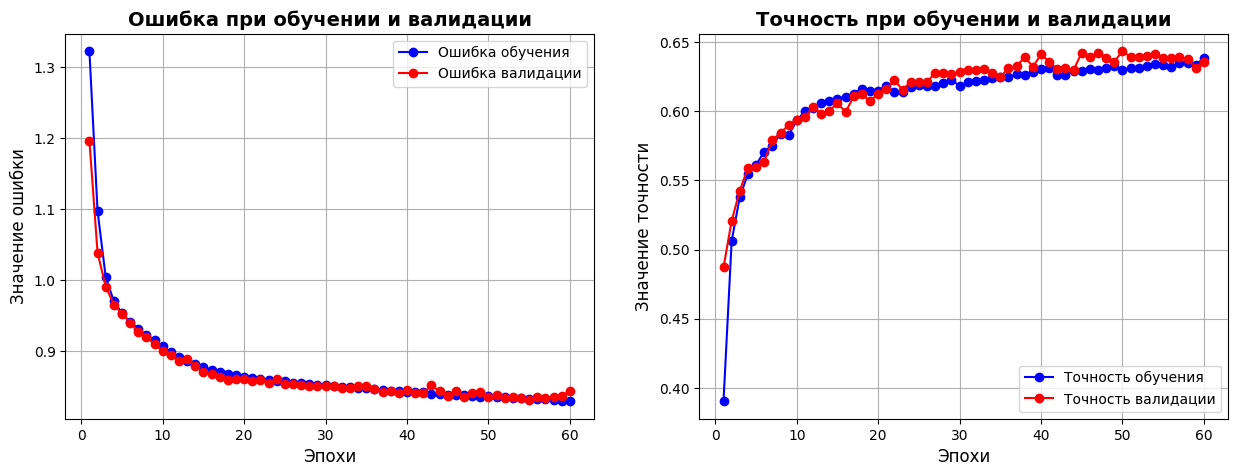

In [195]:
plot_training_curves(history1)

In [196]:
y_predicted_prob = model1.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 1ms/step


In [197]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.6287
Precision_score:	0.6226
Recall_score:		0.6286
F1_score:		0.6207
AUC Score:		0.8591

Accuracy Score 0:	0.8175
Accuracy Score 1:	0.3844
Accuracy Score 2:	0.5373
Accuracy Score 3:	0.7758

              precision    recall  f1-score   support

           0       0.62      0.82      0.71       674
           1       0.48      0.38      0.43       679
           2       0.59      0.54      0.56       657
           3       0.81      0.78      0.79       669

    accuracy                           0.63      2679
   macro avg       0.62      0.63      0.62      2679
weighted avg       0.62      0.63      0.62      2679



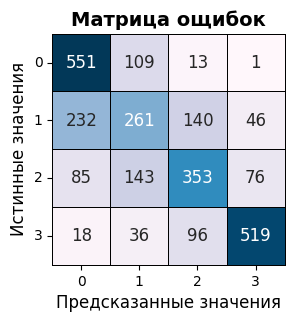

In [198]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

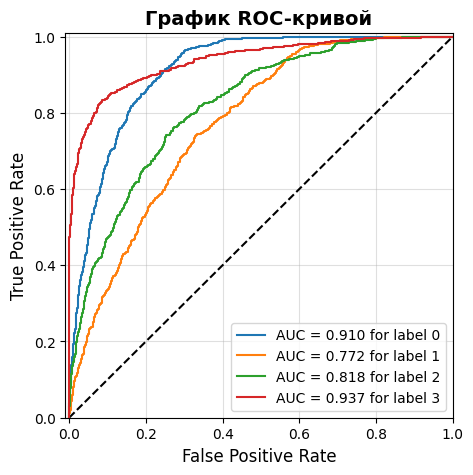

In [199]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 2 оптимизатор RMSprop

In [200]:
model2 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(4, activation="softmax")
])

In [201]:
# компиляция модели
model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 32)                224       
                                                                 
 dense_148 (Dense)           (None, 64)                2112      
                                                                 
 dropout_34 (Dropout)        (None, 64)                0         
                                                                 
 dense_149 (Dense)           (None, 64)                4160      
                                                                 
 dropout_35 (Dropout)        (None, 64)                0         
                                                                 
 dense_150 (Dense)           (None, 32)                2080      
                                                                 
 dense_151 (Dense)           (None, 16)              

### Обучение

In [202]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/100
268/268 [==============================] - 2s 5ms/step - loss: 1.0446 - accuracy: 0.5236 - val_loss: 0.9463 - val_accuracy: 0.5693
Epoch 2/100
268/268 [==============================] - 1s 4ms/step - loss: 0.9385 - accuracy: 0.5821 - val_loss: 0.8945 - val_accuracy: 0.5912
Epoch 3/100
268/268 [==============================] - 1s 4ms/step - loss: 0.9079 - accuracy: 0.5918 - val_loss: 0.8641 - val_accuracy: 0.6094
Epoch 4/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8831 - accuracy: 0.6068 - val_loss: 0.8635 - val_accuracy: 0.6127
Epoch 5/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8709 - accuracy: 0.6118 - val_loss: 0.8351 - val_accuracy: 0.6304
Epoch 6/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8582 - accuracy: 0.6197 - val_loss: 0.8274 - val_accuracy: 0.6342
Epoch 7/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8501 - accuracy: 0.6183 - val_loss: 0.8134 - val_accuracy: 0.6426

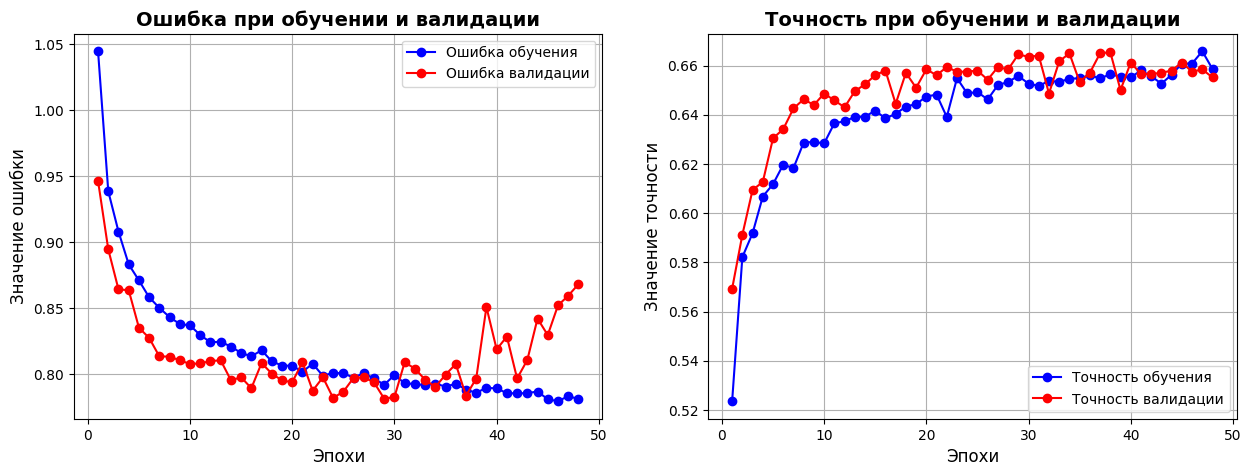

In [203]:
plot_training_curves(history2)

In [204]:
y_predicted_prob = model2.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 2ms/step


In [205]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.6416
Precision_score:	0.6381
Recall_score:		0.6417
F1_score:		0.6366
AUC Score:		0.8717

Accuracy Score 0:	0.8027
Accuracy Score 1:	0.4477
Accuracy Score 2:	0.5282
Accuracy Score 3:	0.7877

              precision    recall  f1-score   support

           0       0.64      0.80      0.71       674
           1       0.50      0.45      0.47       679
           2       0.60      0.53      0.56       657
           3       0.81      0.79      0.80       669

    accuracy                           0.64      2679
   macro avg       0.64      0.64      0.64      2679
weighted avg       0.64      0.64      0.64      2679



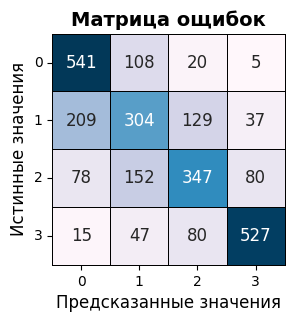

In [206]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

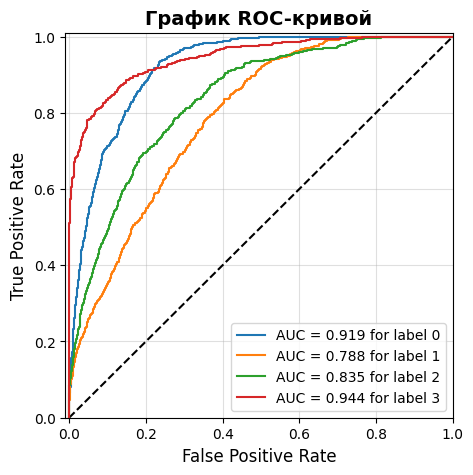

In [207]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)

## Модель 2 оптимизатор RMSprop больше do

In [208]:
model2 = keras.Sequential([
    layers.Dense(32, input_dim=X_train.shape[1], activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(4, activation="softmax")
])

In [209]:
# компиляция модели
model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 32)                224       
                                                                 
 dense_154 (Dense)           (None, 64)                2112      
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dropout_37 (Dropout)        (None, 64)                0         
                                                                 
 dense_156 (Dense)           (None, 32)                2080      
                                                                 
 dense_157 (Dense)           (None, 16)              

### Обучение

In [210]:
history2 = model2.fit(X_train,
                      y_train,
                      epochs=100,
                      validation_data=(X_val, y_val),
                      callbacks=callbacks_list
                      )

Epoch 1/100
268/268 [==============================] - 2s 4ms/step - loss: 1.0890 - accuracy: 0.4824 - val_loss: 0.9250 - val_accuracy: 0.5791
Epoch 2/100
268/268 [==============================] - 1s 3ms/step - loss: 0.9551 - accuracy: 0.5685 - val_loss: 0.8783 - val_accuracy: 0.6150
Epoch 3/100
268/268 [==============================] - 1s 3ms/step - loss: 0.9220 - accuracy: 0.5910 - val_loss: 0.8594 - val_accuracy: 0.6262
Epoch 4/100
268/268 [==============================] - 1s 3ms/step - loss: 0.8985 - accuracy: 0.6035 - val_loss: 0.8526 - val_accuracy: 0.6286
Epoch 5/100
268/268 [==============================] - 1s 4ms/step - loss: 0.8933 - accuracy: 0.6032 - val_loss: 0.8371 - val_accuracy: 0.6407
Epoch 6/100
268/268 [==============================] - 1s 5ms/step - loss: 0.8874 - accuracy: 0.6089 - val_loss: 0.8398 - val_accuracy: 0.6356
Epoch 7/100
268/268 [==============================] - 1s 4ms/step - loss: 0.8749 - accuracy: 0.6141 - val_loss: 0.8352 - val_accuracy: 0.6365

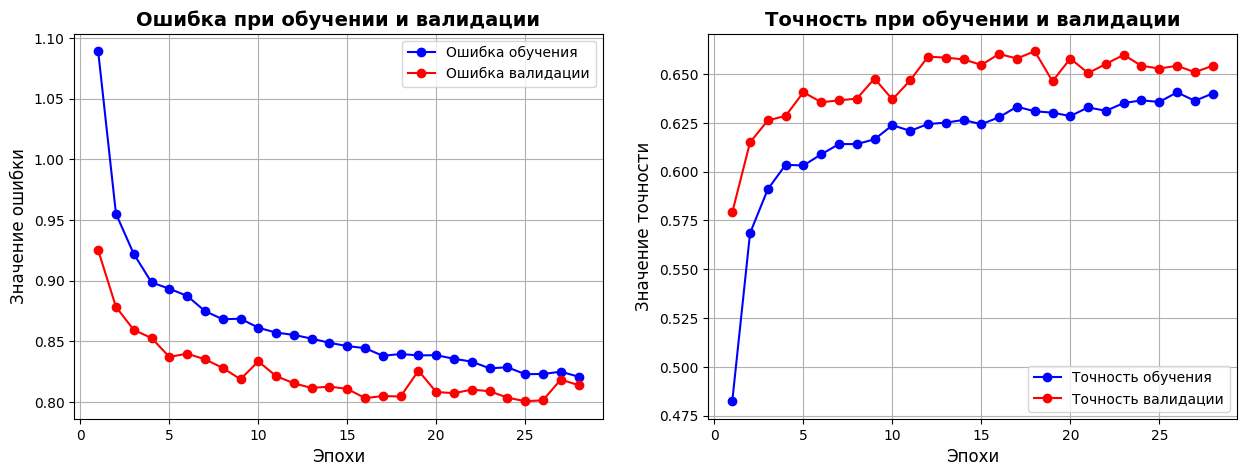

In [211]:
plot_training_curves(history2)

In [212]:
y_predicted_prob = model2.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

84/84 [==============================] - 0s 2ms/step


In [213]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.6505
Precision_score:	0.6452
Recall_score:		0.6502
F1_score:		0.6437
AUC Score:		0.8709

Accuracy Score 0:	0.8086
Accuracy Score 1:	0.4138
Accuracy Score 2:	0.5860
Accuracy Score 3:	0.7937

              precision    recall  f1-score   support

           0       0.65      0.81      0.72       674
           1       0.53      0.41      0.46       679
           2       0.59      0.59      0.59       657
           3       0.82      0.79      0.81       669

    accuracy                           0.65      2679
   macro avg       0.65      0.65      0.64      2679
weighted avg       0.65      0.65      0.64      2679



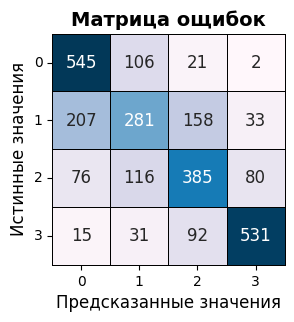

In [214]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))

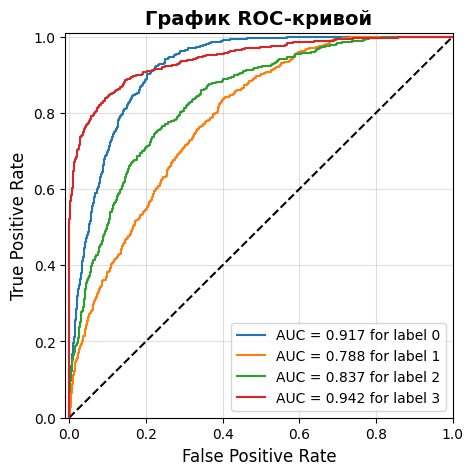

In [215]:
plot_multiclass_roc(y_test, y_predicted_prob, 4)